In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.optim as optim

# Set random seed for reproducibility
torch.manual_seed(69)
np.random.seed(69)

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

def accuracy(forecasts,targets):
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    # Avoid division by zero issues: We assume no zero differences
    # If zero differences can occur, we need a different approach.
    mask = (np.abs(forecasts*targets) > 0)
    temp = np.zeros_like(forecasts)
    temp[mask] = (forecasts[mask]*targets[mask]/np.abs(forecasts[mask]*targets[mask]))
    temp[temp==-1]=0
    accuracy_of_sign  = np.sum(temp)/len(forecasts)

    matches = temp==1
    mismatches = temp==0
    diff_values_matches = np.abs(targets[matches] - forecasts[matches]) if np.any(matches) else np.array([np.nan])
    diff_values_mismatches = np.abs(targets[mismatches] - forecasts[mismatches]) if np.any(mismatches) else np.array([np.nan])
    avg_price_paid_mismatches = np.mean(np.abs(targets[mismatches])) if np.any(mismatches) else np.nan
    avg_price_recieved_matches = np.mean(np.abs(targets[matches])) if np.any(matches) else np.nan
    std_price_paid_mismatches = np.std(np.abs(targets[mismatches])) if np.any(mismatches) else np.nan
    std_price_recieved_matches = np.std(np.abs(targets[matches])) if np.any(matches) else np.nan

    return accuracy_of_sign, np.nanmean(diff_values_matches), np.nanmean(diff_values_mismatches), avg_price_paid_mismatches, avg_price_recieved_matches, std_price_paid_mismatches, std_price_recieved_matches

def revenues(forecasts,targets):
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    mask = (np.abs(forecasts*targets) > 0)
    temp = np.zeros_like(forecasts)
    temp[mask] = (forecasts[mask]*targets[mask]/np.abs(forecasts[mask]*targets[mask]))
    revenues  = np.sum(temp*targets)
    return revenues

class PricePredictionDataset(Dataset):
    def __init__(self, data, target_column='DA'):
        self.data = data
        self.target_column = target_column
        self.X, self.Y = self.prepare_data()

    def prepare_data(self):
        df = self.data
        # Assuming 690 days as per original code
        num_days = 690  
        assert len(df) >= num_days * 24, "Data does not have enough rows for 690 days."

        # Prepare Y (Targets)
        Y = np.zeros((num_days, 24))
        for d in range(num_days):
            Y[d, :] = df.loc[df.index[d * 24:(d + 1) * 24], self.target_column].to_numpy()
        Y = Y[7:-1, :]  # skip first 7 days and last day as per original logic

        # Prepare X (Features)
        X = np.zeros((700 + 1, 726))
        for d in range(7, 690 + 1):
            # The indexing code must match your original logic
            # For brevity, omitted detailed comments. Replicate original indexing carefully.

            # DA (just as example)
            X[d, :24] = df.loc[df.index[(d - 1) * 24:d * 24], 'DA'].to_numpy()
            X[d, 24:48] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'DA'].to_numpy()
            X[d, 48:72] = df.loc[df.index[(d - 3) * 24:(d - 2) * 24], 'DA'].to_numpy()

            # ID
            X[d, 72:96] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'ID'].to_numpy()
            X[d, 96:120] = df.loc[df.index[(d - 1) * 24:d * 24], 'ID'].to_numpy()
            X[d, 120:144] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'ID'].to_numpy()
            X[d, 144:168] = df.loc[df.index[(d - 3) * 24:(d - 2) * 24], 'ID'].to_numpy()
            X[d, 168:192] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'ID'].to_numpy()

            # Demand
            X[d, 192:216] = df.loc[df.index[d * 24:(d + 1) * 24], 'Demand'].to_numpy()
            X[d, 216:240] = df.loc[df.index[(d - 1) * 24:d * 24], 'Demand'].to_numpy()
            X[d, 240:264] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'Demand'].to_numpy()

            # Hour_Cos and Hour_Sin (Indices as in original code)
            X[d, 288:312] = df.loc[df.index[d * 24:(d + 1) * 24], 'Hour_Cos'].to_numpy()
            X[d, 336:360] = df.loc[df.index[d * 24:(d + 1) * 24], 'Hour_Sin'].to_numpy()

            # Day_Cos, Day_Sin, Month_Cos, Month_Sin (just one value per day)
            X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
            X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
            X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Month_Cos'].to_numpy()
            X[d, 363] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Month_Sin'].to_numpy()

            # Weekday
            X[d, 364] = df.loc[df.index[d * 24:(d + 1) * 24:24], 'Weekday'].to_numpy()

            # Predicted wind/solar and other features (indices as per original code)
            X[d, 365:389] = df.loc[df.index[d * 24:(d + 1) * 24], 'Madrid_wind_v_component_Predicted'].to_numpy()
            X[d, 389:413] = df.loc[df.index[d * 24:(d + 1) * 24], 'Madrid_wind_u_component_Predicted'].to_numpy()
            X[d, 413:437] = df.loc[df.index[d * 24:(d + 1) * 24], 'Barcelona_wind_v_component_Predicted'].to_numpy()
            X[d, 437:461] = df.loc[df.index[d * 24:(d + 1) * 24], 'Barcelona_wind_u_component_Predicted'].to_numpy()

            X[d, 461:485] = df.loc[df.index[d * 24:(d + 1) * 24], 'Madrid_solar_radiation'].to_numpy()
            X[d, 485:509] = df.loc[df.index[d * 24:(d + 1) * 24], 'Seville_solar_radiation'].to_numpy()

            X[d, 509:533] = df.loc[df.index[(d - 1) * 24:d * 24], 'Madrid_solar_radiation'].to_numpy()
            X[d, 533:557] = df.loc[df.index[(d - 1) * 24:d * 24], 'Seville_solar_radiation'].to_numpy()

            X[d, 557:581] = df.loc[df.index[(d - 1) * 24:d * 24], 'Castile-La Mancha (Wind)_wind_v_component'].to_numpy()
            X[d, 581:605] = df.loc[df.index[(d - 1) * 24:d * 24], 'Castile-La Mancha (Wind)_wind_u_component'].to_numpy()

            X[d, 629:653] = df.loc[df.index[(d - 1) * 24:d * 24], 'Wind_Generation'].to_numpy()
            X[d, 653:677] = df.loc[df.index[(d - 1) * 24:d * 24], 'PV_Generation'].to_numpy()
            X[d, 677:701] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'Wind_Generation'].to_numpy()
            X[d, 701:725] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'PV_Generation'].to_numpy()

        X = X[7:-1, :]  # matches Y indexing
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class ProbNNModel(nn.Module):
    def __init__(self, input_size, output_size, distribution):
        super(ProbNNModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.distribution = distribution

        # Define layers
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        if distribution == 'Normal':
            self.fc4 = nn.Linear(128, output_size * 2)  # loc and scale
        else:
            raise NotImplementedError(f"Distribution {distribution} not implemented.")

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        loc = x[:, :self.output_size]
        scale = 3e-3 + 3 * F.softplus(x[:, self.output_size:])
        return loc, scale

class NegativeLogLikelihood(nn.Module):
    def __init__(self):
        super(NegativeLogLikelihood, self).__init__()

    def forward(self, loc, scale, target):
        two_pi = torch.tensor(2.0 * np.pi, device=loc.device, dtype=loc.dtype)
        log_prob = -0.5 * (torch.log(two_pi) + torch.log(scale**2) + ((target - loc)**2) / (scale**2))
        return -torch.mean(log_prob)

def train_model(model, train_loader, val_loader, params):
    criterion = NegativeLogLikelihood()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    epochs = params.get('epochs', 500)
    best_val_loss = float('inf')
    best_model_weights = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            loc, scale = model(inputs)
            loss = criterion(loc, scale, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                loc, scale = model(inputs)
                loss = criterion(loc, scale, targets)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = model.state_dict()

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model

def evaluate_model(model, loader):
    model.eval()
    forecasts, targets, scales = [], [], []
    with torch.no_grad():
        for inputs, target in loader:
            loc, scale = model(inputs)
            forecasts.append(loc)
            targets.append(target)
            scales.append(scale)

    forecasts_flat = torch.cat(forecasts, axis=0).flatten()
    targets_flat = torch.cat(targets, axis=0).flatten()
    scales_flat = torch.cat(scales, axis=0).flatten()

    return forecasts_flat, targets_flat, scales_flat

### Load data
my_old_columns = [
    'Year', 'Month', 'Day', 'Hour', 'DA', 'ID', 'Demand', 'Wind_Generation',
    'PV_Generation', 'Predicted_Demand', 'Price_EUR_MWh', 'Volume_MWh',
    'Weekday', 'Castile-La Mancha (Wind)_wind_u_component',
    'Castile-La Mancha (Wind)_wind_v_component',
    'Escatrón-Chiprana-Samper (Solar)_solar_radiation',
    'Madrid_solar_radiation', 'Madrid_wind_u_component',
    'Madrid_wind_v_component', 'Seville_solar_radiation',
    'Seville_wind_u_component', 'Seville_wind_v_component',
    'Madrid_wind_v_component_Predicted', 'Madrid_wind_u_component_Predicted',
    'Valencia_temperature', 'Barcelona_wind_u_component_Predicted',
    'Barcelona_wind_v_component_Predicted', 'Hour_Sin', 'Hour_Cos',
    'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos', 'Diff'
]

data_spain = pd.read_csv(r'../formatted_data/formatted_data_withWeatherPrediction.csv')
data_spain['Weekday'] = pd.to_datetime(data_spain[['Year', 'Month', 'Day']]).dt.weekday
data_spain['Diff'] = data_spain['DA'] - data_spain['ID']
if 'valid_time' in data_spain.columns:
    data_spain = data_spain.drop(columns=['valid_time'])
data_spain = data_spain[my_old_columns]

### Create a dataset for DA (for indexing)
full_da_dataset = PricePredictionDataset(data_spain, target_column='DA')
data_split = 0.9
train_size = int(data_split * len(full_da_dataset))
val_size = len(full_da_dataset) - train_size
train_dataset_da, val_dataset_da = random_split(full_da_dataset, [train_size, val_size])

# Extract the indices used for train/val
train_indices = train_dataset_da.indices
val_indices = val_dataset_da.indices

# Create datasets for ID and Diff with the same indexing
full_id_dataset = PricePredictionDataset(data_spain, target_column='ID')
full_diff_dataset = PricePredictionDataset(data_spain, target_column='Diff')

# Create subsets for ID
train_dataset_id = torch.utils.data.Subset(full_id_dataset, train_indices)
val_dataset_id = torch.utils.data.Subset(full_id_dataset, val_indices)

# Create subsets for Diff
train_dataset_diff = torch.utils.data.Subset(full_diff_dataset, train_indices)
val_dataset_diff = torch.utils.data.Subset(full_diff_dataset, val_indices)

# DataLoaders
batch_size = 32
train_loader_da = DataLoader(train_dataset_da, batch_size=batch_size, shuffle=True)
val_loader_da = DataLoader(val_dataset_da, batch_size=batch_size, shuffle=False)

train_loader_id = DataLoader(train_dataset_id, batch_size=batch_size, shuffle=True)
val_loader_id = DataLoader(val_dataset_id, batch_size=batch_size, shuffle=False)

train_loader_diff = DataLoader(train_dataset_diff, batch_size=batch_size, shuffle=True)
val_loader_diff = DataLoader(val_dataset_diff, batch_size=batch_size, shuffle=False)

# Train models for DA, ID, and Diff
input_size = full_da_dataset.X.shape[1]
output_size = 24

def run_training_and_evaluation(train_loader, val_loader, target_name):
    model = ProbNNModel(input_size=input_size, output_size=output_size, distribution='Normal')
    params = {'learning_rate': 0.0001, 'epochs': 500}
    if target_name == 'Diff':
        params['epochs'] = 550
    if target_name == 'ID':
        params['epochs'] = 600
    model = train_model(model, train_loader, val_loader, params)
    forecasts_flat, targets_flat, scales_flat = evaluate_model(model, val_loader)

    mse_loss = nn.MSELoss()
    mse = mse_loss(forecasts_flat, targets_flat)
    rmse = torch.sqrt(mse)
    print(f"{target_name} RMSE: {rmse.item():.4f}")

    return forecasts_flat, targets_flat, scales_flat

# DA
forecasts_da, targets_da, scales_da = run_training_and_evaluation(train_loader_da, val_loader_da, 'DA')

# ID
forecasts_id, targets_id, scales_id = run_training_and_evaluation(train_loader_id, val_loader_id, 'ID')

# Diff
forecasts_diff, targets_diff, scales_diff = run_training_and_evaluation(train_loader_diff, val_loader_diff, 'Diff')

# Now you can compute accuracy and revenues on the same sets, since indexing is consistent
acc_da, mean_match_da, mean_mismatch_da, avg_paid_mismatch_da, avg_rec_match_da, std_paid_mismatch_da, std_rec_match_da = accuracy(forecasts_da, targets_da)
rev_da = revenues(forecasts_da, targets_da)

print("DA Model:")
print("Sign Accuracy:", acc_da)
print("Revenues:", rev_da)
print()

acc_id, mean_match_id, mean_mismatch_id, avg_paid_mismatch_id, avg_rec_match_id, std_paid_mismatch_id, std_rec_match_id = accuracy(forecasts_id, targets_id)
rev_id = revenues(forecasts_id, targets_id)

print("ID Model:")
print("Sign Accuracy:", acc_id)
print("Revenues:", rev_id)
print()

acc_diff, mean_match_diff, mean_mismatch_diff, avg_paid_mismatch_diff, avg_rec_match_diff, std_paid_mismatch_diff, std_rec_match_diff = accuracy(forecasts_diff, targets_diff)
rev_diff = revenues(forecasts_diff, targets_diff)

print("Diff Model:")
print("Sign Accuracy:", acc_diff)
print("Revenues:", rev_diff)
print()

# Compare results here or plot as needed.


/tmp/ipykernel_524118/1509309081.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
/tmp/ipykernel_524118/1509309081.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
/tmp/ipykernel_524118/1509309081.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 

Epoch 50/500, Train Loss: 5.3767, Val Loss: 5.3193
Epoch 100/500, Train Loss: 5.0841, Val Loss: 4.9984
Epoch 150/500, Train Loss: 4.9433, Val Loss: 4.8660
Epoch 200/500, Train Loss: 4.6352, Val Loss: 4.6807
Epoch 250/500, Train Loss: 4.4452, Val Loss: 4.6233
Epoch 300/500, Train Loss: 4.3353, Val Loss: 4.6837
Epoch 350/500, Train Loss: 4.2667, Val Loss: 4.7116
Epoch 400/500, Train Loss: 4.2076, Val Loss: 4.6716
Epoch 450/500, Train Loss: 4.0695, Val Loss: 4.6749
Epoch 500/500, Train Loss: 4.0147, Val Loss: 4.6958
DA RMSE: 21.3571
Epoch 50/600, Train Loss: 5.3410, Val Loss: 5.2424
Epoch 100/600, Train Loss: 5.0918, Val Loss: 5.0143
Epoch 150/600, Train Loss: 4.9550, Val Loss: 4.9517
Epoch 200/600, Train Loss: 4.8190, Val Loss: 4.8444
Epoch 250/600, Train Loss: 4.5592, Val Loss: 4.8593
Epoch 300/600, Train Loss: 4.4884, Val Loss: 4.8822
Epoch 350/600, Train Loss: 4.3720, Val Loss: 4.8833
Epoch 400/600, Train Loss: 4.2331, Val Loss: 5.1710
Epoch 450/600, Train Loss: 4.1593, Val Loss: 5.05

DA Model:
Sign Accuracy: 0.9583333333333334
Revenues: 122224.984

ID Model:
Sign Accuracy: 0.9456521739130435
Revenues: 119554.45

Diff Model:
Sign Accuracy: 0.5531400966183575
Revenues: 3503.110007558018

DA+ID Model:
Sign Accuracy: 0.48429951690821255
Revenues: 2145.850028378889



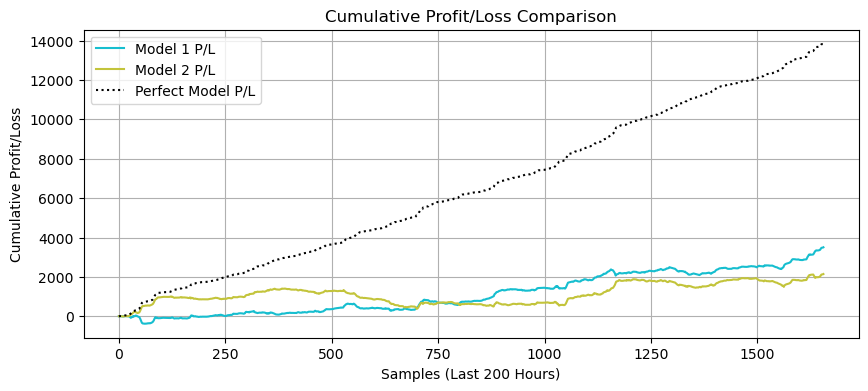

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Convert to numpy if tensors
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

def revenues_with_shorting(forecasts, targets):
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    # Determine if the sign is correct for each point
    sign_correct = (forecasts * targets) > 0

    # If sign is correct, we gain abs(target)
    # If sign is incorrect, we lose abs(target)
    gains = np.abs(targets) * (2 * sign_correct - 1)  # +abs(target) if correct, -abs(target) if incorrect

    # Total revenue is just the sum of these gains
    return np.sum(gains)


# Now you can compute accuracy and revenues on the same sets, since indexing is consistent
acc_da, mean_match_da, mean_mismatch_da, avg_paid_mismatch_da, avg_rec_match_da, std_paid_mismatch_da, std_rec_match_da = accuracy(forecasts_da, targets_da)
rev_da = revenues(forecasts_da, targets_da)

print("DA Model:")
print("Sign Accuracy:", acc_da)
print("Revenues:", rev_da)
print()

acc_id, mean_match_id, mean_mismatch_id, avg_paid_mismatch_id, avg_rec_match_id, std_paid_mismatch_id, std_rec_match_id = accuracy(forecasts_id, targets_id)
rev_id = revenues(forecasts_id, targets_id)

print("ID Model:")
print("Sign Accuracy:", acc_id)
print("Revenues:", rev_id)
print()

acc_diff, mean_match_diff, mean_mismatch_diff, avg_paid_mismatch_diff, avg_rec_match_diff, std_paid_mismatch_diff, std_rec_match_diff = accuracy(forecasts_diff, targets_diff)
rev_diff = revenues_with_shorting(forecasts_diff, targets_diff)

print("Diff Model:")
print("Sign Accuracy:", acc_diff)
print("Revenues:", rev_diff)
print()

# Sign accuracy of DA-ID model
acc_diff_sep, mean_match_diff_sep, mean_mismatch_diff_sep, avg_paid_mismatch_diff_sep, avg_rec_match_diff_sep, std_paid_mismatch_diff_sep, std_rec_match_diff_sep = accuracy(forecasts_id - forecasts_da, targets_da - targets_id)
rev_diff_sep = revenues_with_shorting(forecasts_da-forecasts_id, targets_da - targets_id)

print("DA+ID Model:")
print("Sign Accuracy:", acc_diff_sep)
print("Revenues:", rev_diff_sep)
print()

# Compare results here or plot as needed.

# Also assume predicted_diff_separate and diff_targets are computed as:
predicted_diff_separate = forecasts_da - forecasts_id
diff_targets = targets_da - targets_id

# Define plot length
plot_length = len(forecasts_da)
beginning = 0
end = len(forecasts_da)
forecasts_da_np = to_numpy(forecasts_da)[beginning:end]
targets_da_np = to_numpy(targets_da)[beginning:end]
scales_da_np = to_numpy(scales_da)[beginning:end]

forecasts_id_np = to_numpy(forecasts_id)[beginning:end]
targets_id_np = to_numpy(targets_id)[beginning:end]
scales_id_np = to_numpy(scales_id)[beginning:end]

forecasts_diff_np = to_numpy(forecasts_diff)[beginning:end]
targets_diff_np = to_numpy(targets_diff)[beginning:end]
scales_diff_np = to_numpy(scales_diff)[beginning:end]

predicted_diff_separate_np = to_numpy(predicted_diff_separate)[beginning:end]
diff_targets_np = to_numpy(diff_targets)[beginning:end]

# Profit/Loss calculation
def profit_loss_series(pred_diff, actual_diff):
    sign_correct = (pred_diff * actual_diff) > 0
    profit_loss_values = (2 * sign_correct - 1) * np.abs(actual_diff)
    return np.cumsum(profit_loss_values)

cumulative_profit_loss_diff = profit_loss_series(forecasts_diff_np, diff_targets_np)
cumulative_profit_loss_sep = profit_loss_series(predicted_diff_separate_np, diff_targets_np)
cumulative_profit_loss_perfect = np.cumsum(np.abs(diff_targets_np))

###########################################
# Determine common y-limits for DA and ID forecasts
###########################################
da_min = np.min([targets_da_np, 
                 forecasts_da_np - 1.96*scales_da_np, 
                 forecasts_da_np + 1.96*scales_da_np])
da_max = np.max([targets_da_np, 
                 forecasts_da_np - 1.96*scales_da_np, 
                 forecasts_da_np + 1.96*scales_da_np])

id_min = np.min([targets_id_np, 
                 forecasts_id_np - 1.96*scales_id_np, 
                 forecasts_id_np + 1.96*scales_id_np])
id_max = np.max([targets_id_np, 
                 forecasts_id_np - 1.96*scales_id_np, 
                 forecasts_id_np + 1.96*scales_id_np])

common_min_da_id = min(da_min, id_min)
common_max_da_id = max(da_max, id_max)



###########################################
# Compute combined scales for DA+ID difference model
###########################################
diff_scales_separate_np = np.sqrt(scales_da_np**2 + scales_id_np**2)

# Determine common y-limits for the difference subplots
sep_min = np.min([diff_targets_np, 
                  predicted_diff_separate_np - 1.96 * diff_scales_separate_np,
                  predicted_diff_separate_np + 1.96 * diff_scales_separate_np])
sep_max = np.max([diff_targets_np, 
                  predicted_diff_separate_np - 1.96 * diff_scales_separate_np,
                  predicted_diff_separate_np + 1.96 * diff_scales_separate_np])

diff_min_val = np.min([diff_targets_np, 
                       forecasts_diff_np - 1.96 * scales_diff_np,
                       forecasts_diff_np + 1.96 * scales_diff_np])
diff_max_val = np.max([diff_targets_np, 
                       forecasts_diff_np - 1.96 * scales_diff_np,
                       forecasts_diff_np + 1.96 * scales_diff_np])

common_min_diff = min(sep_min, diff_min_val)
common_max_diff = max(sep_max, diff_max_val)


###########################################
# 4. Cumulative Revenues
###########################################
plt.figure(figsize=(10,4))
plt.plot(cumulative_profit_loss_diff, label='Model 1 P/L', color='#16BECF')
plt.plot(cumulative_profit_loss_sep, label='Model 2 P/L', color='#C3C43B')
plt.plot(cumulative_profit_loss_perfect, label='Perfect Model P/L', color='black', linestyle=':')
plt.title("Cumulative Profit/Loss Comparison")
plt.xlabel("Samples (Last 200 Hours)")
plt.ylabel("Cumulative Profit/Loss")
plt.legend()
plt.grid(True)
plt.show()





DA Model:
Sign Accuracy: 0.9583333333333334
Revenues: 122224.984

ID Model:
Sign Accuracy: 0.9456521739130435
Revenues: 119554.45

Diff Model:
Sign Accuracy: 0.5531400966183575
Revenues: 4023.63

DA+ID Model:
Sign Accuracy: 0.48429951690821255
Revenues: -1026.1298



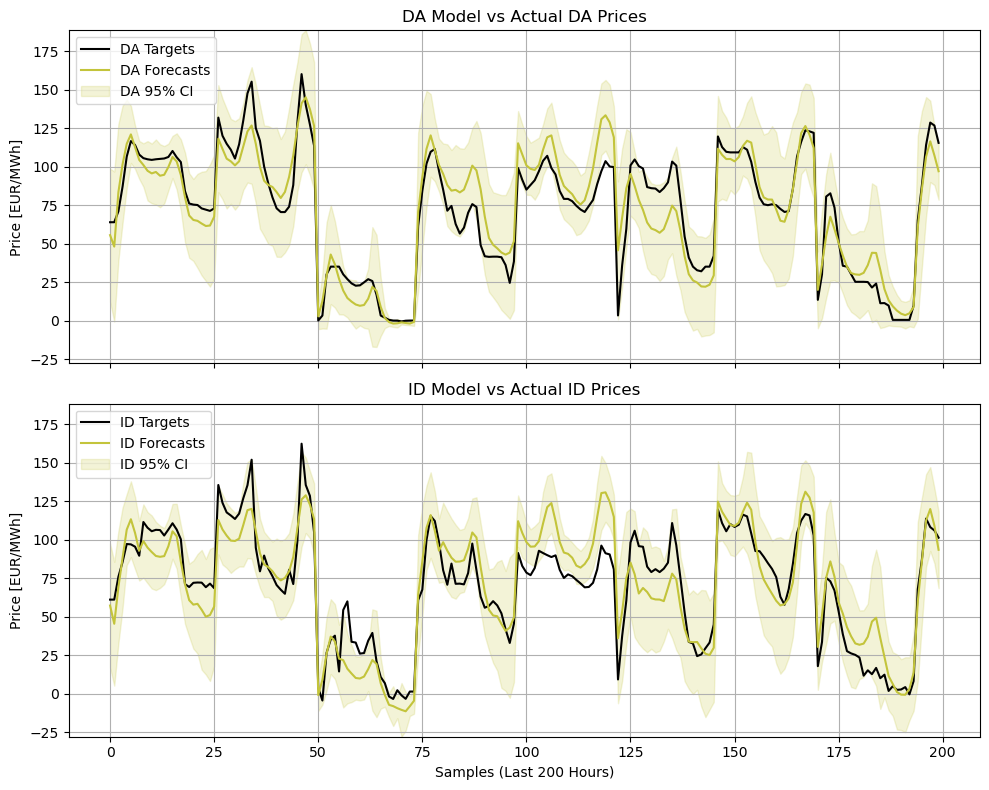

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Convert to numpy if tensors
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

# Now you can compute accuracy and revenues on the same sets, since indexing is consistent
acc_da, mean_match_da, mean_mismatch_da, avg_paid_mismatch_da, avg_rec_match_da, std_paid_mismatch_da, std_rec_match_da = accuracy(forecasts_da, targets_da)
rev_da = revenues(forecasts_da, targets_da)

print("DA Model:")
print("Sign Accuracy:", acc_da)
print("Revenues:", rev_da)
print()

acc_id, mean_match_id, mean_mismatch_id, avg_paid_mismatch_id, avg_rec_match_id, std_paid_mismatch_id, std_rec_match_id = accuracy(forecasts_id, targets_id)
rev_id = revenues(forecasts_id, targets_id)

print("ID Model:")
print("Sign Accuracy:", acc_id)
print("Revenues:", rev_id)
print()

acc_diff, mean_match_diff, mean_mismatch_diff, avg_paid_mismatch_diff, avg_rec_match_diff, std_paid_mismatch_diff, std_rec_match_diff = accuracy(forecasts_diff, targets_diff)
rev_diff = revenues(forecasts_diff, targets_diff)

print("Diff Model:")
print("Sign Accuracy:", acc_diff)
print("Revenues:", rev_diff)
print()

# Sign accuracy of DA-ID model
acc_diff_sep, mean_match_diff_sep, mean_mismatch_diff_sep, avg_paid_mismatch_diff_sep, avg_rec_match_diff_sep, std_paid_mismatch_diff_sep, std_rec_match_diff_sep = accuracy(forecasts_id - forecasts_da, targets_da - targets_id)
rev_diff_sep = revenues(forecasts_id - forecasts_da, targets_da - targets_id)

print("DA+ID Model:")
print("Sign Accuracy:", acc_diff_sep)
print("Revenues:", rev_diff_sep)
print()

# Compare results here or plot as needed.

# Also assume predicted_diff_separate and diff_targets are computed as:
predicted_diff_separate = forecasts_da - forecasts_id
diff_targets = targets_da - targets_id

# Define plot length
plot_length = 200
beginning = 262
end = 462
forecasts_da_np = to_numpy(forecasts_da)[beginning:end]
targets_da_np = to_numpy(targets_da)[beginning:end]
scales_da_np = to_numpy(scales_da)[beginning:end]

forecasts_id_np = to_numpy(forecasts_id)[beginning:end]
targets_id_np = to_numpy(targets_id)[beginning:end]
scales_id_np = to_numpy(scales_id)[beginning:end]

forecasts_diff_np = to_numpy(forecasts_diff)[beginning:end]
targets_diff_np = to_numpy(targets_diff)[beginning:end]
scales_diff_np = to_numpy(scales_diff)[beginning:end]

predicted_diff_separate_np = to_numpy(predicted_diff_separate)[beginning:end]
diff_targets_np = to_numpy(diff_targets)[beginning:end]

# Profit/Loss calculation
def profit_loss_series(pred_diff, actual_diff):
    sign_correct = (pred_diff * actual_diff) > 0
    profit_loss_values = (2 * sign_correct - 1) * np.abs(actual_diff)
    return np.cumsum(profit_loss_values)

cumulative_profit_loss_diff = profit_loss_series(forecasts_diff_np, diff_targets_np)
cumulative_profit_loss_sep = profit_loss_series(predicted_diff_separate_np, diff_targets_np)
cumulative_profit_loss_perfect = np.cumsum(np.abs(diff_targets_np))

###########################################
# Determine common y-limits for DA and ID forecasts
###########################################
da_min = np.min([targets_da_np, 
                 forecasts_da_np - 1.96*scales_da_np, 
                 forecasts_da_np + 1.96*scales_da_np])
da_max = np.max([targets_da_np, 
                 forecasts_da_np - 1.96*scales_da_np, 
                 forecasts_da_np + 1.96*scales_da_np])

id_min = np.min([targets_id_np, 
                 forecasts_id_np - 1.96*scales_id_np, 
                 forecasts_id_np + 1.96*scales_id_np])
id_max = np.max([targets_id_np, 
                 forecasts_id_np - 1.96*scales_id_np, 
                 forecasts_id_np + 1.96*scales_id_np])

common_min_da_id = min(da_min, id_min)
common_max_da_id = max(da_max, id_max)



###########################################
# 5. One figure with two subplots:
#    Top: DA vs targets with CI
#    Bottom DI vs targets with CI
###########################################

fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# Top subplot: DA model
axes[0].plot(targets_da_np, label='DA Targets', color='black')
axes[0].plot(forecasts_da_np, label='DA Forecasts', color='#C3C43B')
axes[0].fill_between(np.arange(plot_length),
                     forecasts_da_np - 1.96 * scales_da_np,
                     forecasts_da_np + 1.96 * scales_da_np,
                     color='#C3C43B', alpha=0.2, label='DA 95% CI')
axes[0].set_title("DA Model vs Actual DA Prices")
axes[0].set_ylabel("Price [EUR/MWh]")
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(common_min_da_id, common_max_da_id)  # Apply common y-limits

# Bottom subplot: ID model
axes[1].plot(targets_id_np, label='ID Targets', color='black')
axes[1].plot(forecasts_id_np, label='ID Forecasts', color='#C3C43B')
axes[1].fill_between(np.arange(plot_length),
                     forecasts_id_np - 1.96 * scales_id_np,
                     forecasts_id_np + 1.96 * scales_id_np,
                     color='#C3C43B', alpha=0.2, label='ID 95% CI')
axes[1].set_title("ID Model vs Actual ID Prices")
axes[1].set_xlabel("Samples (Last 200 Hours)")
axes[1].set_ylabel("Price [EUR/MWh]")
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(common_min_da_id, common_max_da_id)  # Apply common y-limits

plt.tight_layout()
plt.show()



In [24]:
# Lets make a function, that goes through the forecasts and targets and gives the beginning and end of a period where the rmse is the lowest, and the rmse of that period, and we give the period length as a parameter
def find_best_period(forecasts, targets, period_length):

    # Convert to numpy if tensors
    def to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        return x

    forecasts_np = to_numpy(forecasts)
    targets_np = to_numpy(targets)

    # Calculate the rmse for all periods
    rmse_values = []
    for i in range(len(forecasts_np) - period_length):
        rmse = np.sqrt(np.mean((forecasts_np[i:i+period_length] - targets_np[i:i+period_length])**2))
        rmse_values.append(rmse)

    # Find the period with the lowest rmse
    best_period_index = np.argmin(rmse_values)
    best_period_rmse = rmse_values[best_period_index]

    return best_period_index, best_period_index + period_length, best_period_rmse

# Lets find the best period for the DA model
best_period_da_start, best_period_da_end, best_period_da_rmse = find_best_period(forecasts_da, targets_da, 200)
print("Best period for DA model:", best_period_da_start)
print("Best period for DA model:", best_period_da_end)
print("Best period for DA model:", best_period_da_rmse)

# Lets find the best period for the ID model
best_period_id_start, best_period_id_end, best_period_id_rmse = find_best_period(forecasts_id, targets_id, 200)
print("Best period for ID model:", best_period_id_start)
print("Best period for ID model:", best_period_id_end)
print("Best period for ID model:", best_period_id_rmse)

# Lets find the best period for the Diff model
best_period_diff_start, best_period_diff_end, best_period_diff_rmse = find_best_period(forecasts_diff, targets_diff, 200)
print("Best period for Diff model:", best_period_diff_start)
print("Best period for Diff model:", best_period_diff_end)
print("Best period for Diff model:", best_period_diff_rmse)

# Now lets make a function that goes through both the da and id forecasts and targets and gives the beginning and end of a period where the rmse is the lowest, and the rmse of that period, and we give the period length as a parameter

def find_best_period_da_id(forecasts_da, targets_da, forecasts_id, targets_id, period_length):
    
    # Convert to numpy if tensors
    def to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        return x

    forecasts_da_np = to_numpy(forecasts_da)
    targets_da_np = to_numpy(targets_da)
    forecasts_id_np = to_numpy(forecasts_id)
    targets_id_np = to_numpy(targets_id)

    # Calculate the rmse for all periods
    rmse_values = []
    for i in range(len(forecasts_da_np) - period_length):
        rmse = np.sqrt(np.mean((forecasts_da_np[i:i+period_length] - targets_da_np[i:i+period_length])**2) + np.mean((forecasts_id_np[i:i+period_length] - targets_id_np[i:i+period_length])**2))
        rmse_values.append(rmse)

    # Find the period with the lowest rmse
    best_period_index = np.argmin(rmse_values)
    best_period_rmse = rmse_values[best_period_index]

    return best_period_index, best_period_index + period_length, best_period_rmse

# Lets find the best period for the DA+ID model
best_period_da_id_start, best_period_da_id_end, best_period_da_id_rmse = find_best_period_da_id(forecasts_da, targets_da, forecasts_id, targets_id, 200)
print("Best period for DA+ID model:", best_period_da_id_start)
print("Best period for DA+ID model:", best_period_da_id_end)
print("Best period for DA+ID model:", best_period_da_id_rmse)




Best period for DA model: 262
Best period for DA model: 462
Best period for DA model: 13.867639
Best period for ID model: 1338
Best period for ID model: 1538
Best period for ID model: 15.571766
Best period for Diff model: 92
Best period for Diff model: 292
Best period for Diff model: 7.6877947
Best period for DA+ID model: 262
Best period for DA+ID model: 462
Best period for DA+ID model: 20.936552


In [44]:
def accuracy(forecasts, targets):
    # Convert to numpy if they are not already
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.detach().cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.detach().cpu().numpy()

    # Avoid division by zero by adding a small constant where needed
    denominator = np.abs(forecasts * targets)
    denominator[denominator == 0] = 1e-8  # Small constant to avoid division by zero

    # Compute sign correctness
    temp = forecasts * targets / denominator
    temp[temp == -1] = 0  # Convert -1 to 0 for accuracy calculation

    accuracy_of_sign = np.sum(temp) / len(forecasts)


    matches = temp == 1
    mismatches = temp == 0

    diff_values_matches = np.abs(targets[matches] - forecasts[matches])
    diff_values_mismatches = np.abs(targets[mismatches] - forecasts[mismatches])

    avg_price_paid_mismatches = np.mean(np.abs(targets[mismatches]))
    avg_price_recieved_matches = np.mean(np.abs(targets[matches]))
    std_price_paid_mismatches = np.std(np.abs(targets[mismatches]))
    std_price_recieved_matches = np.std(np.abs(targets[matches]))

    return (accuracy_of_sign,
            np.mean(diff_values_matches),
            np.mean(diff_values_mismatches),
            avg_price_paid_mismatches,
            avg_price_recieved_matches,
            std_price_paid_mismatches,
            std_price_recieved_matches)

def revenues(forecasts, targets):
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.detach().cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.detach().cpu().numpy()

    # Check sign correctness
    sign_correct = (forecasts * targets) > 0
    # Gains and losses are always the absolute value of the target difference
    # Correct sign: +|targets|
    # Incorrect sign: -|targets|
    revenues = np.sum((2 * sign_correct - 1) * np.abs(targets))
    return revenues


# Now you can compute accuracy and revenues on the same sets, since indexing is consistent
# we are going to compare the results of the DA model results - ID model results with the Diff model results
acc_diff_sep, mean_match_diff_sep, mean_mismatch_diff_sep, avg_paid_mismatch_diff_sep, avg_rec_match_diff_sep, std_paid_mismatch_diff_sep, std_rec_match_diff_sep = accuracy(forecasts_da - forecasts_id, targets_da - targets_id)
rev_diff_sep = revenues(forecasts_da - forecasts_id, targets_da - targets_id)

print("DA-ID Model:")
print("Sign Accuracy:", acc_diff_sep)
print("Revenues:", rev_diff_sep)
print("Standard Deviation of Paid Mismatches:", std_paid_mismatch_diff_sep)
print("Standard Deviation of Received Matches:", std_rec_match_diff_sep)
print()
acc_diff, mean_match_diff, mean_mismatch_diff, avg_paid_mismatch_diff, avg_rec_match_diff, std_paid_mismatch_diff, std_rec_match_diff = accuracy(forecasts_diff, targets_diff)
rev_diff = revenues(forecasts_diff, targets_diff)

print("Diff Model:")
print("Sign Accuracy:", acc_diff)
print("Revenues:", rev_diff)
print("Standard Deviation of Paid Mismatches:", std_paid_mismatch_diff)
print("Standard Deviation of Received Matches:", std_rec_match_diff)
print()




DA-ID Model:
Sign Accuracy: 0.5144927536231884
Revenues: 2145.850028378889
Standard Deviation of Paid Mismatches: 7.5701375
Standard Deviation of Received Matches: 10.72971

Diff Model:
Sign Accuracy: 0.5531400966183575
Revenues: 3503.110007558018
Standard Deviation of Paid Mismatches: 8.070896
Standard Deviation of Received Matches: 10.19871

